## Введение

Рассмотрим задачу pruning'а нейросетевых моделей, а именно — ResNet20 для датасета CIFAR-10 из оригинальной статьи [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). Сначала реализуем архитектуру модели ResNet20, затем обучим ее на датасете CIFAR-10, создадим класс для реализации filter-level метода pruning'а и сравним результаты его применения для различных параметров класса.

## Импортирование модулей и файлов

In [1]:
import os
os.makedirs('runs', exist_ok=True)

In [2]:
import imp
import torch
import torch.nn as nn
from IPython.display import clear_output
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [ ]:
!pip install albumentations==0.5.1

Основные реализации всех моделей и вспомогательных методов находятся в файлах `resnet.py`, `prune_model.py`, `train_utils.py` и `pruning_utils.py`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
!cp 'drive/My Drive/Colab Notebooks/CV/Pruning/train_utils.py' .
!cp 'drive/My Drive/Colab Notebooks/CV/Pruning/pruning_utils.py' .
!cp 'drive/My Drive/Colab Notebooks/CV/Pruning/prune_model.py' .
!cp 'drive/My Drive/Colab Notebooks/CV/Pruning/resnet.py' .

In [6]:
root_path = '/content/cifar10'
os.makedirs(root_path, exist_ok=True)

## Обучение модели ResNet20 на датасете CIFAR-10

In [ ]:
import train_utils
imp.reload(train_utils)

In [41]:
from train_utils import train, train_model, evaluate, get_train_val_loader, get_test_loader, get_test_results

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 4
batch_size = 128
val_ratio = 0.1

train_loader, val_loader = get_train_val_loader(data_dir=root_path,
                                                batch_size=batch_size,
                                                val_size=val_ratio,
                                                num_workers=num_workers)

test_loader = get_test_loader(data_dir=root_path,
                              batch_size=batch_size,
                              num_workers=num_workers)

In [10]:
import resnet
imp.reload(resnet)
from resnet import create_resnet20

Создадим экземпляр класса ResNet20 и обучим модель с теми параметрами, которые были указаны в оригинальной статье. На графиках показан loss на текущей эпохе, средний loss по эпохам на обучающей и валидационной выборке, а также accuracy по эпохам на обучающей и валидационной выборке.

In [11]:
resnet20_model = create_resnet20()

In [ ]:
resnet20_model.to(device)

In [13]:
n_epochs = 100
opt = torch.optim.SGD(resnet20_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[50, 75], gamma=0.1, last_epoch=-1)

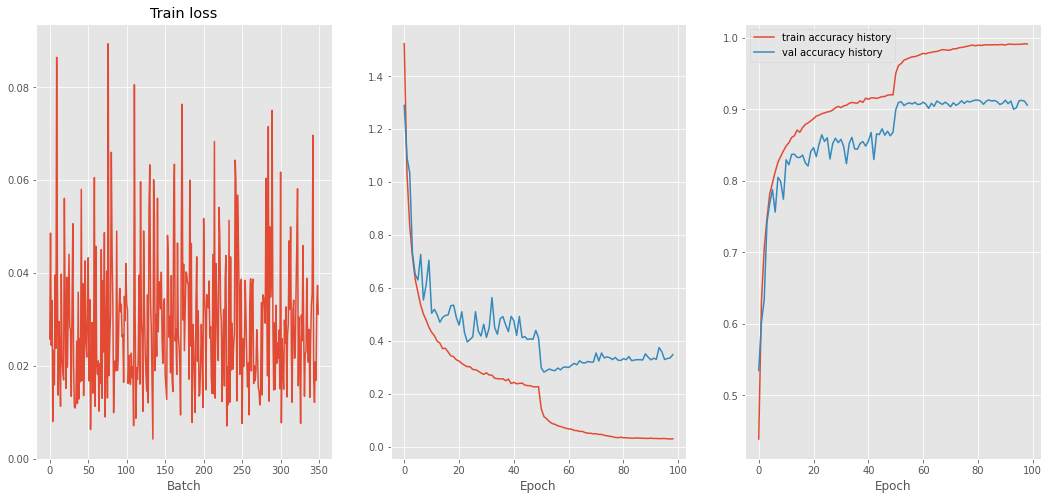

Epoch: 100 | Time: 0m 28s
	Train Loss: 0.029
	 Val. Loss: 0.329


In [14]:
train_model(resnet20_model, 
            device, 
            train_loader, 
            val_loader, 
            opt, 
            criterion, 
            lr_scheduler, 
            n_epochs, 
            clip=1, 
            model_name='resnet20_model.pth')

Посмотрим на accuracy полученной модели на тестовой выборке.

In [15]:
get_test_results(resnet20_model, device, test_loader, criterion)

Loss on the test data: 0.354
Accuracy on test data: 0.907


Итак, точность обученной сети находится примерно на уровне 90%.

## Pruning

Реализуем метод pruning'а, который состоит из следующих двух шагов:
<br>
1. Для каждого сверточного слоя кластеризуется набор сверток, его представляющий (тензор весов), при этом кластеризация проводится отдельно для каждого слоя.
2. Каждая исходная свертка в определенном слое заменяется на центроид кластера, к которому она была отнесена на шаге 1.

Заметим, что в такой постановке задачи сама архитектура модели не изменяется, меняются ли веса модели (при этом не происходит зануление весов). В качестве метода кластеризации я решил использовать метод KMeans. Данная функциональность реализована в классе `NaiveClusterModel`.

In [16]:
import pruning_utils
import prune_model

In [17]:
from prune_model import NaiveClusterModel

В качестве параметров класса выступает словарь, где ключу соответсвует номер сверточного слоя, а значению — количество кластеров, которое мы хотим получить на данном слое.
<br>
Проверим, корректно ли алгоритм работает, если в качестве значений передать реальное количество сверток на каждом слое. То есть ожидается получить на каждом слое кластеры, состоящие только лишь из одного вектора признаков, соответствующего определенному фильтру. Таким образом в итоге ожидается получить ту же модель, которая была подана на вход, имеющая то же качество.

In [ ]:
cluster_args = {
    'n_clusters_per_layer': {2: 16, 4: 16, 6: 16, 8: 16, 10: 16, 12: 16,
                             14: 32, 16: 32, 18: 32, 20: 32, 22: 32, 24: 32, 26: 32, 
                             28: 64, 30: 64, 32: 64, 34: 64, 36: 64, 38: 64, 40: 64}
}

cl_model = NaiveClusterModel(resnet20_model, cluster_args)
resnet20_cl = cl_model.cluster_model()
resnet20_cl.to(device)

In [29]:
get_test_results(resnet20_cl, device, test_loader, criterion)

Loss on the test data: 0.356
Accuracy on test data: 0.907


Видно, что качество модели не изменилось, то есть в результате была получена сама модель.

Попробуем проварьировать число кластеров на определенных слоях и посмотреть на результаты работы метода.

In [40]:
for i in range(2, 17, 2):
    cluster_args = {
        'n_clusters_per_layer': {2: i, 4: i, 6: i, 8: i, 10: i, 12: i,
                                 14: i, 16: i, 18: i, 20: i, 22: i, 24: i, 26: i, 
                                 28: i, 30: i, 32: i, 34: i, 36: i, 38: i, 40: i}
    }

    cl_model = NaiveClusterModel(resnet20_model, cluster_args)
    resnet20_cl = cl_model.cluster_model()
    resnet20_cl.to(device)
    print("Results for {} clusters on each layer:".format(i))
    get_test_results(resnet20_cl, device, test_loader, criterion)
    print('\n')

Results for 2 clusters on each layer:
Loss on the test data: 4.929
Accuracy on test data: 0.099


Results for 4 clusters on each layer:
Loss on the test data: 4.490
Accuracy on test data: 0.102


Results for 6 clusters on each layer:
Loss on the test data: 7.457
Accuracy on test data: 0.100


Results for 8 clusters on each layer:
Loss on the test data: 4.515
Accuracy on test data: 0.101


Results for 10 clusters on each layer:
Loss on the test data: 6.193
Accuracy on test data: 0.109


Results for 12 clusters on each layer:
Loss on the test data: 7.747
Accuracy on test data: 0.101


Results for 14 clusters on each layer:
Loss on the test data: 8.779
Accuracy on test data: 0.101


Results for 16 clusters on each layer:
Loss on the test data: 7.727
Accuracy on test data: 0.095




Видно, что при одинаковом количестве кластеров на каждом слое (максимум 16 кластеров, т.к. иначе в первом блоке сверток невозможно будет произвести кластеризацию, на нем их всего 16) точность полученной модели очень низкая.

Попробуем различное случайное количество кластеров для каждого сверточного слоя (их всего 20), при этом будем ограничивать количество кластеров в каждом из трех блоков сверток из модели ResNet20 (в блоках 6, 7 и 7 сверточных слоев соответственно).

In [48]:
from random import randint

In [66]:
def experiment_with_clusters_numbers(layer_idx, n_experiments, l_b_1, u_b_1, l_b_2, u_b_2, l_b_3, u_b_3):
    # l_b_i and u_b_i are the lower and upper bounds of the number of clusters
    # for each convolutional layer in three blocks of ResNet20

    for _ in range(n_experiments):
        cl_1 = [randint(l_b_1, u_b_1) for _ in range(6)]
        cl_2 = [randint(l_b_2, u_b_2) for _ in range(7)]
        cl_3 = [randint(l_b_3, u_b_3) for _ in range(7)]
        clusters = [*cl_1, *cl_2, *cl_3]
        cluster_args = {
            'n_clusters_per_layer': dict(zip(layer_idx, clusters))
        }

        cl_model = NaiveClusterModel(resnet20_model, cluster_args)
        resnet20_cl = cl_model.cluster_model()
        resnet20_cl.to(device)

        print("Results for clusters {}:".format(clusters))
        get_test_results(resnet20_cl, device, test_loader, criterion)
        print('\n')

In [67]:
layer_idx = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]

Попробуем случайное количество кластеров на каждом слое в максимальном диапазоне возможных значений.

In [68]:
experiment_with_clusters_numbers(layer_idx, 5, 2, 16, 2, 32, 2, 64)

Results for clusters [7, 16, 14, 6, 10, 15, 32, 16, 12, 3, 20, 9, 3, 61, 51, 7, 27, 13, 22, 33]:
Loss on the test data: 12.488
Accuracy on test data: 0.101


Results for clusters [3, 14, 7, 4, 12, 10, 3, 11, 19, 7, 14, 19, 23, 28, 44, 17, 5, 50, 31, 50]:
Loss on the test data: 19.409
Accuracy on test data: 0.099


Results for clusters [6, 9, 2, 10, 14, 14, 15, 2, 7, 16, 20, 14, 26, 40, 50, 15, 17, 47, 38, 32]:
Loss on the test data: 9.944
Accuracy on test data: 0.100


Results for clusters [8, 16, 8, 11, 14, 15, 30, 32, 14, 2, 24, 27, 16, 13, 22, 4, 61, 46, 13, 17]:
Loss on the test data: 7.911
Accuracy on test data: 0.170


Results for clusters [6, 12, 13, 8, 6, 7, 28, 15, 22, 15, 11, 11, 29, 18, 58, 50, 15, 35, 29, 49]:
Loss on the test data: 17.062
Accuracy on test data: 0.101




Заметим, что качество полученных моделей также является низким.

Попробуем большое количество слоев в первом и третьем блоке, при этом во втором блоке — меньшее количество.

In [69]:
experiment_with_clusters_numbers(layer_idx, 5, 14, 16, 5, 10, 60, 64)

Results for clusters [15, 15, 14, 16, 15, 14, 5, 7, 9, 10, 10, 8, 10, 63, 63, 61, 61, 62, 63, 64]:
Loss on the test data: 7.523
Accuracy on test data: 0.086


Results for clusters [15, 14, 14, 15, 16, 15, 9, 9, 10, 5, 10, 6, 9, 63, 63, 61, 62, 64, 61, 64]:
Loss on the test data: 6.948
Accuracy on test data: 0.100


Results for clusters [15, 15, 15, 15, 14, 16, 5, 8, 10, 10, 9, 10, 6, 61, 61, 61, 61, 62, 60, 62]:
Loss on the test data: 5.971
Accuracy on test data: 0.100


Results for clusters [15, 15, 16, 15, 16, 14, 8, 5, 5, 5, 9, 9, 9, 60, 63, 60, 60, 60, 61, 64]:
Loss on the test data: 6.319
Accuracy on test data: 0.100


Results for clusters [16, 14, 14, 14, 15, 15, 5, 9, 8, 6, 6, 5, 6, 62, 63, 62, 64, 64, 61, 64]:
Loss on the test data: 7.110
Accuracy on test data: 0.102




Также видно, что качество моделей не получается высоким.

Попробуем количество кластеров, близкое к изначальному количеству сверток в каждом слое.

In [71]:
experiment_with_clusters_numbers(layer_idx, 5, 14, 16, 28, 32, 60, 64)

Results for clusters [16, 15, 16, 14, 16, 14, 29, 28, 28, 30, 28, 29, 32, 64, 60, 60, 64, 63, 63, 63]:
Loss on the test data: 0.744
Accuracy on test data: 0.821


Results for clusters [15, 15, 15, 14, 14, 16, 29, 32, 31, 31, 29, 31, 31, 60, 64, 61, 63, 61, 60, 60]:
Loss on the test data: 1.193
Accuracy on test data: 0.731


Results for clusters [14, 16, 14, 15, 16, 16, 30, 31, 31, 32, 30, 32, 32, 62, 61, 61, 63, 60, 64, 64]:
Loss on the test data: 0.543
Accuracy on test data: 0.867


Results for clusters [15, 16, 15, 14, 14, 15, 32, 30, 31, 32, 28, 31, 30, 63, 61, 60, 60, 64, 63, 64]:
Loss on the test data: 0.807
Accuracy on test data: 0.808


Results for clusters [16, 14, 14, 14, 15, 16, 29, 29, 31, 29, 31, 28, 29, 62, 60, 64, 60, 63, 61, 61]:
Loss on the test data: 1.321
Accuracy on test data: 0.709




В данном случае уже видно, что качество стало заметно лучше, но при этом все равно значительно меньше качества исходной модели.

Итак, можно заметить, что качество полученных моделей значительно падает при использовании меньшего количества кластеров, при этом можно приблизиться к качеству исходной модели, но при этом практически не отходя от истинного количества сверток в слоях.

## Мысли и идеи

Можно предположить, что данный подход не очень хорошо работает из-за используемого внутри метода кластеризации, а также из-за слишком наивного выбора признаков для сверток на каждом слое (весь тензор весов просто "вытягивался" в вектор для получения признаков отдельной свертки). 

Изначально я приступил к изучению статьи [CUP: Cluster Pruning for Compressing Deep Neural Networks](https://arxiv.org/abs/1911.08630) (так как немного неправильно понял исходную задачу), в которой применяется агломеративная иерархическая кластеризация векторов признаков слоев (с учетом признаков со следующего слоя), при этом архитектура полученной сети изменяется, вектора признаков считаются по-другому, а также делается выбор подмножества фильтров из кластеров (в статье используется один фильтр в качестве "представителя" кластера) согласно L2-норме признаков. Такой подход позволил авторам статьи получить высокие результаты после применения pruning'а, поэтому я думаю, что такая идея могла бы улучшить результаты. Я попробовал реализовать такой подход (ориентируясь на исходный код, который доступен в открытом доступе и ссылка на который указана в статье), но при этом немного не дошел до конца (пока не разобрался, как окончательно сделать так, чтобы все размерности сверточных слоев были согласованы; проблема в размерностях для residual connections). Данный код доступен в файле `prune_model.py`, класс `ArchModClusterModel`. 